In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy.optimize
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from pytorchtools import CNN, GaussianNoise
from adversarialbox.attacks import FGSMAttack, LinfPGDAttack_AE, WassDROAttack_AE, L2PGDAttack_AE
from adversarialbox.train import adv_train, FGSM_train_rnd
from adversarialbox.utils import to_var, pred_batch, test
from layers_compress import Encoder, Generator, Quantizer, AutoencoderQ, StructuredCompressor, SingleEncMultiDec, SingleEncSingleDec, StructuredRotation
from dro_tools import est_radius, est_radius_structured

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# matplotlib
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'lines.linewidth':1.25})
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["font.family"] = "serif"
# plt.rcParams['mathtext.default'] = 'regular'

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(32),
                                            torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST('../data/', download=True, train=True, transform=transform)                                 
mnist_test = torchvision.datasets.MNIST('../data/', download=True, train=False, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=2048, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=2048, shuffle=True)

In [5]:

def loopy(dl):
    while True:
        for x in iter(dl): yield x

def obj_rot(theta, img_iterator, model, ball):
    x = next(img_iterator)[0].to(device)
    x_rotated = torchvision.transforms.functional.rotate(x, theta)
    x_hat = model(x_rotated) if ball==0 else model(x_rotated,1)
    loss = -32*32*F.mse_loss(x_rotated, x_hat).item()
    return loss

    
def argmax_theta(train_loader, model, ball):
    img_iterator = loopy(train_loader) #shuffles the train_loader
    obj = lambda theta: obj_rot(theta, img_iterator, model, ball)
    theta_max = scipy.optimize.minimize_scalar(obj, bounds=[-180, 180], method='bounded', options={'maxiter': 200, 'disp':3})
    return theta_max

def obj_rot_angle_pred(theta, img_iterator, model):
    x = next(img_iterator)[0].to(device)
    x_rotated = torchvision.transforms.functional.rotate(x, theta)
    x_hat = model(x_rotated, train_angle_net=False)
    loss = -32*32*F.mse_loss(x_rotated, x_hat).item()
    return loss

def gen_save_plot_angle_pred(train_loader, model):
    thetas = np.linspace(-179, 180, 360)
    d_dro = np.zeros(len(thetas))
    iterator = loopy(train_loader)
    for i,theta in enumerate(thetas):
        d_dro[i] = -obj_rot_angle_pred(theta, iterator, model)
    return thetas, d_dro

def gen_save_plot(train_loader, model, ball):
    thetas = np.linspace(-179, 180, 360)
    d_dro = np.zeros(len(thetas))
    iterator = loopy(train_loader)
    for i,theta in enumerate(thetas):
        d_dro[i] = -obj_rot(theta, iterator, model, ball)
    return thetas, d_dro
    # plt.figure()
    # plt.plot(thetas, d_dro)
    # plt.axvline(theta_max, color='k',linestyle='--')
    # plt.xlabel('angle')
    # plt.ylabel('distortion')
    # plt.savefig(f'../plots_rotations/epoch{epoch}_batch{batch}.png')

In [6]:
d_pair = (2, 8)
L = 12
d = 10

In [7]:

# Structured model from Figure 5. First load 'angle_net' which is pretrained using structured_angle_pred.py
saved = torch.load(f'../robust_compression/trained_no_robust2/ae_c_d{8}L{12}.pt', map_location=device)
netE, netQ, netG = saved['netE'], saved['netQ'], saved['netG']
saved = torch.load('trained_angle_pred/angle_net.pt', map_location=device)
netAngle = saved['angle_net']
model_angle_pred = StructuredRotation(netE, netG, netQ, netAngle, 12)
model_angle_pred.eval()

# Robust models
# saved = torch.load(f'trained_dro_rotations/ae_c_d{d}L{L}rotated_globalopt.pt', map_location=device)
saved = torch.load(f'../robust_compression/trained_robust_rotations2/ae_c_d{d}L{L}rotated_globalopt.pt', map_location=device)
model_dro = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

saved = torch.load(f'../robust_compression/trained_robust_rotations_random/ae_c_d{d}L{L}rotated_random.pt', map_location=device)
model_dro2 = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

saved = torch.load(f'../robust_compression/trained_no_robust2/ae_c_d{d_pair[0]+d_pair[1]}L{L}.pt', map_location=device)
model_std = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

saved = torch.load(f'../robust_compression/trained_robust_augmentation/ae_c_d{d}L{L}rotation.pt', map_location=device)
model_da = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

saved = torch.load(f'../robust_compression/trained_robust_augmentation/ae_c_d{d}L{L}rotation_only.pt', map_location=device)
model_da_only = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

In [8]:
# model_dro.train()
# model_struct.train()
# model_struct_DA.eval()

loader = test_loader
with torch.no_grad():
  thetas, d_dro = gen_save_plot(loader, model_dro, 0)
  _, d_dro2 = gen_save_plot(loader, model_dro2, 0)
  _, d_da = gen_save_plot(loader, model_da, 0)
  _, d_da_only = gen_save_plot(loader, model_da_only, 0)
  _, d_std = gen_save_plot(loader, model_std, 0)
  # _, d_struct2 = gen_save_plot(loader, model_struct2, 1)
  # _, d_struct = gen_save_plot(loader, model_struct, 1)
  _, d_angle_pred = gen_save_plot_angle_pred(loader, model_angle_pred)

/home/eric/miniconda3/envs/torch2/lib/python3.9/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/eric/miniconda3/envs/torch2/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


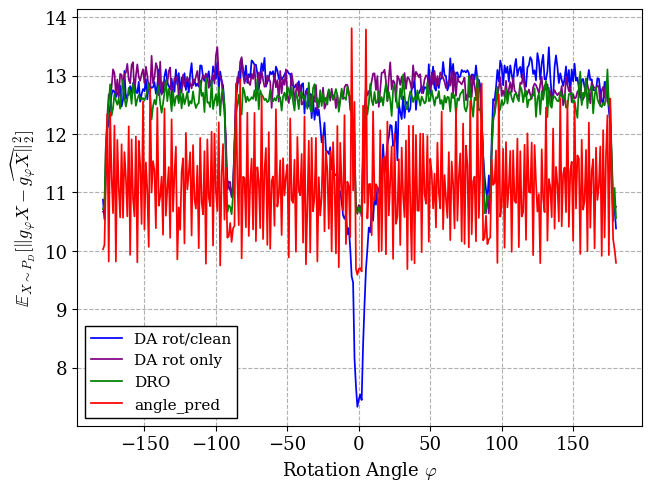

In [9]:
plt.figure(constrained_layout=True)
plt.plot(thetas, d_da, label='DA rot/clean')
plt.plot(thetas, d_da_only, label='DA rot only', color='purple')
plt.plot(thetas, d_dro, label='DRO')
plt.plot(thetas, d_angle_pred, label='angle_pred')
plt.legend(loc='best',prop={'size': 11})
plt.xlabel(r'Rotation Angle $\varphi$')
plt.ylabel(r'$\mathbb{E}_{X\sim P_D}[\|g_\varphi X-\widehat{g_\varphi X}\|_2^2]$')
plt.grid(linestyle='--', which='both')
plt.show()
# plt.savefig('plots_rotations/rotations_struct_angle_pred_global.pdf')